In [ ]:
'''
# Train a memory network on the bAbI dataset.
References:
- https://github.com/keras-team/keras/blob/master/examples/babi_memnn.py
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  ["Towards AI-Complete Question Answering:
  A Set of Prerequisite Toy Tasks"](http://arxiv.org/abs/1502.05698)
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  ["End-To-End Memory Networks"](http://arxiv.org/abs/1503.08895)
Reaches 94.3% accuracy on task 'single_supporting_fact_10k' after 120 epochs.
Time per epoch: 4s on CPU (core i7).

The components like tokenizer and parser are 
'''
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re


def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)?', sent) if x.strip()]


def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data


def vectorize_stories(data):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))

try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise


challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_'
                                  'single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_'
                                'two-supporting-facts_{}.txt',
}
challenge_type = 'two_supporting_facts_10k'
challenge = challenges[challenge_type]

print('Extracting stories for the challenge:', challenge_type)
with tarfile.open(path) as tar:
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))



# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64, 
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)


# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence) # Meaning that "inputs = input_sequence"
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

num_hops=3
for i in range(num_hops):
    print(i)
    
    #DEBUG
    print("input_sequence", input_sequence.get_shape())
    print("question", question.get_shape())
    print("input_encoded_m", input_encoded_m.get_shape())
    print("input_encoded_c", input_encoded_c.get_shape())
    print("question_encoded", question_encoded.get_shape())
    
    
    # compute a 'match' between the first input vector sequence
    # and the question vector sequence
    # shape: `(samples, story_maxlen, query_maxlen)`
    match = dot([input_encoded_m, question_encoded], axes=2)
    print("match", match.get_shape())    
    match = Activation('softmax')(match)
    
    # add the match matrix with the second input vector sequence
    response = dot([match, input_encoded_c], axes=1)  
    # shape: (samples, story_maxlen, query_maxlen)
    print("response", response.get_shape())
    
    
    question_encoded = add([response, question_encoded])
print(question_encoded.get_shape())


# the original paper uses a matrix multiplication for this reduction step.
final_ans = LSTM(32)(question_encoded)
final_ans = Dropout(0.3)(final_ans)
print(final_ans.get_shape())
final_ans = Dense(vocab_size)(final_ans)  # (samples, vocab_size)


    
# we output a probability distribution over the vocabulary
final_ans = Activation('softmax')(final_ans)

# build the final model
model = Model([input_sequence, question], final_ans)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=120,
          validation_data=([inputs_test, queries_test], answers_test))

Extracting stories for the challenge: two_supporting_facts_10k


/Users/ekremguzelyel/anaconda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


-
Vocab size: 36 unique words
Story max length: 552 words
Query max length: 5 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'got', 'the', 'football', 'there', '.', 'John', 'went', 'to', 'the', 'kitchen', '.', 'Mary', 'went', 'back', 'to', 'the', 'kitchen', '.', 'Mary', 'went', 'back', 'to', 'the', 'garden', '.'], ['Where', 'is', 'the', 'football', '?'], 'garden')
-
Vectorizing the word sequences...
-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 552)
inputs_test shape: (1000, 552)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 5)
queries_test shape: (1000, 5)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000,)
answers_test shape: (1000,)
-
Compiling...
0
input_sequence (?, 552

In [26]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

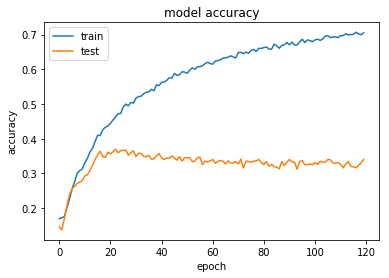

In [27]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model.save("lstm32hops3.model")